In [52]:
# BLOCK 1: Importing Necessary Libraries

# Standard libraries (No installation needed)
import numpy as np
from datetime import datetime
import time
import random  # For Q-learning
from collections import deque

# Install the required libraries using the following commands in your terminal:

# 1. autograd: Automatic differentiation library
# 2. numpy: Numerical operations (part of autograd)
# 3. capytaine: Python library for BEM simulation
# 4. matplotlib: Plotting library
# 5. scipy: Scientific computing library
# 6. wecopttool: Optimization tool for Wave Energy Converters
# 7. joblib: Parallel processing library

# For Intel Chip (macOS):
# ```
# pip install autograd numpy capytaine matplotlib scipy wecopttool joblib
# ```

# For Apple Silicon (macOS with M1/M2 chip):
# ```
# # Ensure you have the correct version of pip and Python installed that supports Apple Silicon.
# pip install autograd numpy matplotlib scipy wecopttool joblib
# # Capytaine installation might require additional steps on Apple Silicon:
# pip install capytaine --no-binary capytaine
# ```

import autograd.numpy as np  # For numerical operations with automatic differentiation
import capytaine as cpy  # Boundary Element Method (BEM) solver for WEC simulations
import matplotlib.pyplot as plt  # For plotting results
from scipy.spatial import KDTree  # For nearest-neighbor queries in Q-learning
from scipy.optimize import brute  # For brute-force optimization
import wecopttool as wot  # Optimization tools for Wave Energy Converters
from wecopttool import geom  # For geometric operations related to WECs
import joblib
from joblib import Parallel, delayed  # For parallel processing in simulations

import pickle
import os
import shutil
import dbm
import dbm.dumb as dbm  # Use dumb

# Add PyTorch for Deep Q-Learning
import torch
import torch.nn as nn
import torch.optim as optim  # Optimizers

In [53]:
# Set the path for the cache on your external drive
cache_path = "/Volumes/Drive1/my_cache_folder/wec_simulation_cache2"

# Ensure the cache directory exists
os.makedirs(os.path.dirname(cache_path), exist_ok=True)

# Open the cache database
db = dbm.open(cache_path, 'c')

# Check the number of entries in the cache
try:
    num_entries = len([key for key in db.keys()])
    print(f"> Cache loaded with {num_entries} entries.")
except Exception as e:
    print(f"Error reading cache entries: {e}")

# Check available space on the external drive
total, used, free = shutil.disk_usage("/Volumes/Drive1")
print(f"> Total space: {total / (1024**3):.2f} GB")
print(f"> Used space: {used / (1024**3):.2f} GB")
print(f"> Free space: {free / (1024**3):.2f} GB")

> Cache loaded with 95263 entries.
> Total space: 1677.91 GB
> Used space: 1.51 GB
> Free space: 1676.40 GB


In [54]:
# BLOCK 2: Initialize the WaveBot environment
wb = wot.geom.WaveBot()  # Use standard dimensions
mesh_size_factor = 0.5  # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

# Define the frequency and other wave parameters
f1 = 0.05
nfreq = 50

stiffness = wot.hydrostatics.stiffness_matrix(fb).values
mass = wot.hydrostatics.inertia_matrix(fb).values
freq = wot.frequency(f1, nfreq, False)  # False -> no zero frequency
bem_data = wot.run_bem(fb, freq)

# Define PTO parameters
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

In [31]:
# # BLOCK 3: Define states and actions for Q-learning

# pto_damping_range_upperlimit=2
# stiffness_range_upperlimit=2

# pto_damping_range_lowerlimit=0.1
# stiffness_range_lowerlimit=0.1

# amplitudes = np.linspace(0.05, 0.1, 10)
# wavefreqs = np.linspace(0.1, 1, 10)
# pto_damping_range = np.linspace(0.1, pto_damping_range_upperlimit, 20)
# stiffness_range = np.linspace(0.1, stiffness_range_upperlimit, 40)

# # Include amplitude, wave frequency, PTO damping, and stiffness in the state space
# states = [(amplitude, wavefreq, pto_damping, stiffness) 
#           for amplitude in amplitudes 
#           for wavefreq in wavefreqs
#           for pto_damping in pto_damping_range
#           for stiffness in stiffness_range]

# # Define actions: Adjust PTO damping or do nothing
# # Each action tuple: (change in PTO damping)
# actions = [-1, 0, 1]  # Decrease, keep, or increase PTO damping

# # Create KDTree for quick nearest-neighbor lookup
# state_tree = KDTree(states)
# print(f"Number Of States: {len(states)}")
# def find_nearest_state(state):
#     _, idx = state_tree.query(state)
#     return states[idx]

In [69]:
# Define action space: Adjust PTO damping or do nothing
actions = [-1, 0, 1]  # Decrease, keep, or increase PTO damping

# Define bounds
#UPPER LIMITS
amplitudes_range_upperlimit = 0.1
wavefreqs_range_upperlimit = 1
pto_damping_range_upperlimit = 2
stiffness_range_upperlimit = 2


amplitudes_range_lowerlimit = 0.05
wavefreqs_range_lowerlimit = 0.1
pto_damping_range_lowerlimit = 0.1
stiffness_range_lowerlimit = 0.1

# Define the function to create states
def create_states(condition):
    if condition == "discrete":
        # Discrete value ranges for each state component
        amplitudes = np.linspace(amplitudes_range_lowerlimit, amplitudes_range_upperlimit, 10)
        wavefreqs = np.linspace(wavefreqs_range_lowerlimit, wavefreqs_range_upperlimit, 10)
        pto_damping_range = np.linspace(pto_damping_range_lowerlimit, pto_damping_range_upperlimit, 20)
        stiffness_range = np.linspace(stiffness_range_lowerlimit, stiffness_range_upperlimit, 40)
        # Generate all combinations of discrete values
        states = [(amplitude, wavefreq, pto_damping, stiffness) 
                  for amplitude in amplitudes 
                  for wavefreq in wavefreqs
                  for pto_damping in pto_damping_range
                  for stiffness in stiffness_range]
        return states
    
    elif condition == "continuous":
        # Generate a single random state within valid ranges
        state = [
            np.random.uniform(amplitudes_range_lowerlimit, amplitudes_range_upperlimit),  # Amplitude range
            np.random.uniform(wavefreqs_range_lowerlimit, wavefreqs_range_upperlimit),  # Wave frequency range
            np.random.uniform(pto_damping_range_lowerlimit, pto_damping_range_upperlimit),  # PTO damping range
            np.random.uniform(stiffness_range_lowerlimit, stiffness_range_upperlimit)  # Stiffness range
        ]
        return [state]  # Wrap it in a list to keep the return type consistent
    else:
        raise ValueError("Condition must be 'discrete' or 'continuous'.")


# Example usage
discrete_states = create_states("discrete")
continuous_state = create_states("continuous")[0]  # Retrieve the single continuous state from the list

print(f"> Discrete states count: {len(discrete_states)}")
print(f"> Sample continuous state: {continuous_state}")

> Discrete states count: 80000
> Sample continuous state: [0.07118280509225347, 0.7001806467596939, 1.4986456415150327, 1.2758359131623755]


In [70]:
# BLOCK 4: Function to select action based on the ε-greedy policy
def select_action(state, epsilon):
    """Select an action using an epsilon-greedy policy with the Q-network."""
    if random.uniform(0, 1) < epsilon:
        # Random action (exploration)
        action = random.choice(actions)
    else:
        # Predict Q-values using the Q-network (exploitation)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor and add batch dimension
        with torch.no_grad():
            q_values = q_network(state_tensor)  # Predict Q-values for the current state
        action_index = torch.argmax(q_values).item()  # Select the action with the highest Q-value
        action = actions[action_index]
    
    return action

In [71]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize Q-network and target network
state_size = 4  # Number of state variables: [amplitude, wavefreq, damping, stiffness]
action_size = len(actions)
q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
target_network.load_state_dict(q_network.state_dict())

# Set optimizer and loss function
optimizer = optim.Adam(q_network.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Experience replay buffer
replay_buffer = deque(maxlen=10000)  # Use a buffer to store experiences

In [72]:
# Initialize random PTO damping and stiffness within their respective ranges
initial_damping = random.uniform(pto_damping_range[0], pto_damping_range[-1])  # Initial PTO damping
initial_stiffness = random.uniform(stiffness_range[0], stiffness_range[-1])  # Initial stiffness

# Set the initial state variables
damping = initial_damping
stiffness = initial_stiffness

print(f"> Initial random PTO damping: {damping}")
print(f"> Initial random stiffness: {stiffness}")

> Initial random PTO damping: 1.0966659876986888
> Initial random stiffness: 0.49437098388855083


In [73]:
# BLOCK 6: Updated Reward function incorporating damping, stiffness powers, scaling, and normalization
def get_reward(opt_mechanical_average_power, damping, stiffness, pto_velocity, pto_displacement):
    # Calculate damping and stiffness power for PTO
    pto_velocity = np.maximum(pto_velocity, 1e-4)  # Avoid zero power terms element-wise
    pto_displacement = np.maximum(pto_displacement, 1e-4)

    # Calculate damping and stiffness power contributions
    damping_power = damping * (pto_velocity ** 2)
    stiffness_power = stiffness * pto_displacement * pto_velocity

    # Introduce weights for damping and stiffness power contributions
    damping_weight = 0.5
    stiffness_weight = 0.5
    total_power = damping_weight * damping_power + stiffness_weight * stiffness_power

    # Introduce weights to balance the influence of different components
    power_weight = 1.0
    penalty_weight = 0.3  # Increased penalty weight for testing

    # Combine mechanical power and penalties
    reward = power_weight * opt_mechanical_average_power - penalty_weight * total_power

    # Scale down the reward
    scaled_reward = reward / 100  # Reduced scaling factor to retain magnitude

    # Normalize the reward with a larger range
    min_reward = -5  # Adjusted minimum based on experimentation
    max_reward = 50  # Adjusted maximum to provide more gradient
    normalized_reward = (scaled_reward - min_reward) / (max_reward - min_reward)

    # Use np.where to avoid ambiguity with arrays
    return np.where(normalized_reward > 0, normalized_reward, np.exp(normalized_reward) - 1)

In [74]:
def run_simulation(state, epsilon, db):
    state_key = (round(state[0], 6), round(state[1], 6), round(state[2], 6), round(state[3], 6))
    print(f"Running simulation with state_key: {state_key}")

    # Check if the state_key exists in the dbm database
    if str(state_key) in db:
        try:
            # Attempt to load the cached value
            cached_value = pickle.loads(db[str(state_key)])
            
            # Check if the cached value is complete
            if len(cached_value) != 4:  # Assuming a complete entry has 4 elements
                print(f"Incomplete cache entry for state: {state_key}, rerunning simulation.")
            else:
                print(f"State found in cache. Cache size: {len(db)}")
                return cached_value
        except (pickle.UnpicklingError, EOFError) as e:
            # Handle the case where the pickle data is corrupted
            print(f"Corrupted cache entry detected for state: {state_key}. Error: {e}")
            # Delete the corrupted cache entry
            del db[str(state_key)]
            print(f"Deleted corrupted cache entry for state: {state_key}.")

    # If the state is not found in the cache or is incomplete, run the simulation
    print("State not found in cache. Running simulation...")
    action = select_action(state, epsilon)  # Use the DQL-based select_action function
    damping = state[2]
    stiffness = state[3]
    
    # Modify damping based on the action
    if action == -1:
        damping = max(0, damping - 0.1)
    elif action == 1:
        damping += 0.1
    
    # Bound damping to valid range
    if damping > pto_damping_range_upperlimit:
        damping = pto_damping_range_upperlimit
    elif damping < pto_damping_range_lowerlimit:
        damping = pto_damping_range_lowerlimit

    # Simulate wave energy conversion
    amplitude = state[0]
    wavefreq = state[1]
    phase = 30
    wavedir = 0
    waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

    # Run WEC simulation
    results = wec.solve(
        waves,
        obj_fun,
        nstate_opt,
        optim_options=options,
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
    )

    opt_mechanical_average_power = -results.fun
    print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')

    # Post-process results
    pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom = wec.post_process(results, waves, nsubsteps=nsubsteps)

    pto_displacement = pto_tdom['pos']
    pto_velocity = pto_tdom['vel']

    # Compute the reward
    reward = get_reward(opt_mechanical_average_power, damping, stiffness, pto_velocity, pto_displacement)

    # Define the next state
    next_state = (state[0], state[1], damping, stiffness)

    # Update the cache with the new simulation result
    db[str(state_key)] = pickle.dumps((reward, next_state, pto_velocity, pto_displacement))
    print(f"Cache updated with new state. Total cache size: {len(db)} entries.")

    # Return the simulation results
    return reward, next_state, pto_velocity, pto_displacement

In [75]:
# BLOCK 14: PTO dynamics forcing function and constraints
f_add = {'PTO': pto.force_on_wec}
f_max = 2000.0  # Maximum allowable PTO force
nsubsteps = 4   # Number of substeps for the integration

# Define the constraint function for PTO force
def const_f_pto(wec, x_wec, x_opt, waves):
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

# Create inequality constraint based on the PTO force
ineq_cons = {'type': 'ineq', 'fun': const_f_pto}
constraints = [ineq_cons]

In [76]:
# BLOCK 15: WEC setup and optimization options

# Initialize the WEC object with BEM data and additional parameters
wec = wot.WEC.from_bem(
    bem_data,  # BEM data for hydrodynamic coefficients
    inertia_matrix=mass,  # Inertia matrix
    hydrostatic_stiffness=stiffness,  # Hydrostatic stiffness matrix
    constraints=constraints,  # Constraints including PTO force limit
    friction=None,  # Friction, can be set if needed
    f_add=f_add,  # Additional forces such as PTO forces
)

# Define the objective function for the optimization
obj_fun = pto.mechanical_average_power  # Maximize average mechanical power

# Number of states to optimize over
nstate_opt = 2 * nfreq  # This could be adjusted based on the frequency range

# Optimization options
options = {'maxiter': 200}  # Maximum number of iterations for the optimizer
scale_x_wec = 1e1  # Scaling factor for the WEC states
scale_x_opt = 1e-3  # Scaling factor for the optimization states
scale_obj = 1e-2  # Scaling factor for the objective function

In [77]:
# def apply_action(state, action):
#     """
#     Apply the chosen action to modify the given state.
#     In this example, the action modifies the PTO damping, while stiffness remains unchanged.
#     """
#     new_state = list(state)
    
#     # Define how each action modifies the damping
#     if action == -1:
#         # Decrease damping
#         new_state[2] = max(new_state[2] - 0.1, pto_damping_range_lowerlimit)
#     elif action == 1:
#         # Increase damping
#         new_state[2] = min(new_state[2] + 0.1, pto_damping_range_upperlimit)
#     # If action is 0, the damping remains unchanged
    
#     # Stiffness remains the same in this version
#     new_state[3] = max(min(new_state[3], stiffness_range_upperlimit), stiffness_range_lowerlimit)

#     return tuple(new_state)

In [78]:
# Set random seed for reproducibility
random.seed(0)
np.random.seed(0)

# Define the number of epochs and select a fixed set of test states
num_test_states = 20  # Number of test states

# Generate random continuous test states within valid ranges
fixed_test_states = [
    (
        np.random.uniform(0.05, 0.1),  # Amplitude range
        np.random.uniform(0.1, 1.0),  # Wave frequency range
        np.random.uniform(pto_damping_range_lowerlimit, pto_damping_range_upperlimit),  # PTO damping range
        np.random.uniform(stiffness_range_lowerlimit, stiffness_range_upperlimit)  # Stiffness range
    )
    for _ in range(num_test_states)
]

# Create dictionaries to store results for each test state across epochs
epoch_rewards = {f"Test State {i+1}": [] for i in range(num_test_states)}
epoch_next_states = {f"Test State {i+1}": [] for i in range(num_test_states)}
q_values_history_test = {f"Test State {i+1}": [] for i in range(num_test_states)}

print(f"Selected fixed test states:")
for i, test_state in enumerate(fixed_test_states):
    print(f"> Test State {i+1}: {test_state}")

Selected fixed test states:
> Test State 1: (0.07744067519636624, 0.7436704297351775, 1.2452504145361234, 1.135278047694104)
> Test State 2: (0.07118273996694524, 0.6813047017599905, 0.9314157013991157, 1.7943687014859515)
> Test State 3: (0.09818313802505146, 0.4450973669431999, 1.6042775723570628, 1.1049003475305186)
> Test State 4: (0.07840222805469663, 0.933036974463395, 0.2349685105759852, 0.26554566943292734)
> Test State 5: (0.05101091987201629, 0.8493578609931441, 1.5784978268047158, 1.7530230816689565)
> Test State 6: (0.0989309171116382, 0.8192427077950513, 0.9768107882805704, 1.5830054349442655)
> Test State 7: (0.05591372129344666, 0.6759289191947714, 0.3723712460771882, 1.8948709423942094)
> Test State 8: (0.07609241608750358, 0.4731957459914713, 0.6026556629987911, 1.5710440099250116)
> Test State 9: (0.07280751661082743, 0.6115905539817836, 0.13570062082907478, 1.2735074444441665)
> Test State 10: (0.08060478613612107, 0.6552405971872812, 1.8931213491777859, 1.3954585682

In [79]:
# Discount Factor
gamma = 0.9  # Increase to consider future rewards more

# Epsilon-Greedy Parameters
epsilon = 0.9  # Initial exploration rate
max_epsilon = epsilon
epsilon_decay = 0.995  # Slightly faster decay rate for exploration
min_epsilon = 0.05  # Minimum exploration rate

# Exploration Parameters
exploration_starts = 20  # Number of episodes to start with full exploration

# Training Parameters
max_episodes = 100  # Training episodes per iteration (can increase if needed) 100
outer_iterations = 200  # Number of outer loops 200

In [80]:
# Tracking Metrics
q_value_history = []  # Average Q-value at each training step
reward_history = []  # Rewards obtained during training
epsilon_history = []  # Epsilon values during training
loss_history = []  # Loss values for training the Q-network
q_value_min_history = []  # Minimum Q-value observed during training
q_value_max_history = []  # Maximum Q-value observed during training
expected_return_history = []  # Expected return values during evaluation

# Note: No need for state_to_index as we are working with continuous states

In [81]:
def update_epsilon(episode, epsilon, exploration_starts):
    """Update epsilon value based on the episode count."""
    if episode >= exploration_starts:
        new_epsilon = max(min_epsilon, epsilon * epsilon_decay)
        print(f"Epsilon updated to {new_epsilon} at episode {episode}")
        return new_epsilon
    return epsilon

def get_reward_value(reward):
    """Ensure reward is a scalar."""
    if isinstance(reward, np.ndarray) and reward.size == 1:
        scalar_reward = reward.item()
    elif isinstance(reward, (np.ndarray, list)):
        scalar_reward = np.mean(reward)
    else:
        scalar_reward = reward
    print(f"Reward value: {scalar_reward}")
    return scalar_reward

def train_q_network():
    """Train the Q-network using mini-batches from the replay buffer."""
    if len(replay_buffer) < 64:  # Ensure enough samples in buffer
        return

    # Sample a mini-batch from the replay buffer
    batch = random.sample(replay_buffer, 64)
    states, actions, rewards, next_states = zip(*batch)

    # Debugging prints to check shapes at each step
    # print(f"Sampled states shape: {np.array(states).shape}")
    # print(f"Sampled actions shape: {np.array(actions).shape}")
    # print(f"Sampled rewards shape: {np.array(rewards).shape}")
    # print(f"Sampled next_states shape: {np.array(next_states).shape}")

    # Convert actions to indices
    action_to_index = {-1: 0, 0: 1, 1: 2}
    action_batch = torch.LongTensor([action_to_index[a] for a in actions])

    # Convert states and next_states to tensors
    state_batch = torch.FloatTensor(np.array(states))
    next_state_batch = torch.FloatTensor(np.array(next_states))

    # Process rewards to remove any unintended dimensions
    rewards = np.array(rewards).reshape(64, -1).mean(axis=1)  # Flatten to [64] by averaging if needed
    reward_batch = torch.FloatTensor(rewards).view(-1, 1)  # Reshape to [64, 1]
    
    # Print to verify shape before proceeding
    # print(f"Processed reward_batch shape: {reward_batch.shape}")
    # print(f"Processed action_batch shape: {action_batch.shape}")
    # print(f"Processed state_batch shape: {state_batch.shape}")
    # print(f"Processed next_state_batch shape: {next_state_batch.shape}")

    # Q-values for current states
    q_values = q_network(state_batch).gather(1, action_batch.unsqueeze(1))

    # Q-values for next states (using target network)
    with torch.no_grad():
        target_q_values = target_network(next_state_batch).max(1)[0].unsqueeze(1)

    # Ensure target_q_values has shape (64, 1)
    # print(f"Processed target_q_values shape: {target_q_values.shape}")

    # Compute the target for the current states
    target = reward_batch + (gamma * target_q_values)

    # Compute the loss
    loss = loss_fn(q_values, target)

    # Update the Q-network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track loss for analysis
    loss_history.append(loss.item())


def run_cached_simulation(state_key, test_state, db):
    """Run simulation for a state and update cache if needed."""
    if str(state_key) in db:
        cached_result = pickle.loads(db[str(state_key)])
        print(f"Loaded cached result for state {state_key}")
        return cached_result[0], cached_result[1]
    else:
        results = run_simulation(test_state, epsilon, db)  # Pass epsilon for action selection
        reward, next_state = results[0], results[1]
        db[str(state_key)] = pickle.dumps(results)
        print(f"Simulated and cached result for state {state_key}")
        return reward, next_state

In [93]:
# Set the desired condition for state space: "discrete" as D or "continuous" as C
state_condition = "D"

# Training and Testing Loop
start_time = time.time()
if state_condition == "D":
    print("Running with DISCRETE states\n")
elif state_condition == "C":
    print("Running with CONTINUOUS states\n")

for iteration in range(outer_iterations):
    # Training Loop
    for episode in range(max_episodes):
        print(f"|> Starting outer iteration {iteration + 1}/{outer_iterations} and inner iteration {episode + 1}/{max_episodes} <|")
        if state_condition == "D":
            state = random.choice(create_states("discrete"))
        elif state_condition == "C":
            state = create_states("continuous")[0]

        # Select action using epsilon-greedy policy with the Q-network
        action = select_action(state, epsilon)

        # Update epsilon
        epsilon = update_epsilon(episode, epsilon, exploration_starts)
        epsilon_history.append(epsilon)

        # Run simulation to get the reward and next state
        reward, next_state, _, _ = run_simulation(state, epsilon, db)

        # Store the experience in the replay buffer
        replay_buffer.append((state, action, reward, next_state))

        # Train the Q-network periodically
        train_q_network()

        # Track rewards and Q-value metrics
        reward_history.append(reward)

    # Testing phase (only one epoch)
    print(f"\nTesting phase after iteration {iteration + 1}/{outer_iterations}")
    total_reward = 0  # Initialize total reward for averaging
    num_test_states = len(fixed_test_states)  # Number of test states

    for i, test_state in enumerate(fixed_test_states):
        # Run cached simulation or new simulation for the test state
        state_key = tuple(round(s, 6) for s in test_state)
        reward, next_state = run_cached_simulation(state_key, test_state, db)
        reward = get_reward_value(reward)

        # Predict Q-values using the Q-network
        with torch.no_grad():
            state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            q_values = q_network(state_tensor)
            max_q_value_next_state = q_values.max().item()

        # Calculate the expected return
        expected_return = reward + gamma * max_q_value_next_state

        # Optionally store or print the expected return
        print(f"Expected return for Test State {i + 1}: {expected_return:.4f}")
        
        # Accumulate total reward
        total_reward += expected_return

    # Calculate and display the average reward for this testing phase
    average_reward = total_reward / num_test_states
    print(f"Average reward for testing phase after iteration {iteration + 1}: {average_reward:.4f}\n\n")
    expected_return_history.append(average_reward)

end_time = time.time()

Running with DISCRETE states

|> Starting outer iteration 1/1 and inner iteration 1/1 <|
Running simulation with state_key: (0.094444, 0.3, 1.4, 1.561538)
State found in cache. Cache size: 95263

Testing phase after iteration 1/1
Loaded cached result for state (0.077441, 0.74367, 1.24525, 1.135278)
Reward value: 0.09335130744790898
Expected return for Test State 1: 0.1241
Loaded cached result for state (0.071183, 0.681305, 0.931416, 1.794369)
Reward value: 0.09345115802085267
Expected return for Test State 2: 0.1446
Loaded cached result for state (0.098183, 0.445097, 1.604278, 1.1049)
Reward value: 0.10912522567120493
Expected return for Test State 3: 0.1725
Loaded cached result for state (0.078402, 0.933037, 0.234969, 0.265546)
Reward value: 0.09144193481011814
Expected return for Test State 4: 0.1685
Loaded cached result for state (0.051011, 0.849358, 1.578498, 1.753023)
Reward value: 0.09144193481011814
Expected return for Test State 5: 0.1685
Loaded cached result for state (0.09893

In [94]:
print(f"> Training and testing completed in {((end_time - start_time)):.4f} seconds.")
print(f"> Training and testing completed in {((end_time - start_time)/60):.4f} minutes.")
print(f"> Training and testing completed in {((end_time - start_time)/3600):.4f} hours.")

> Training and testing completed in 0.5988 seconds.
> Training and testing completed in 0.0100 minutes.
> Training and testing completed in 0.0002 hours.


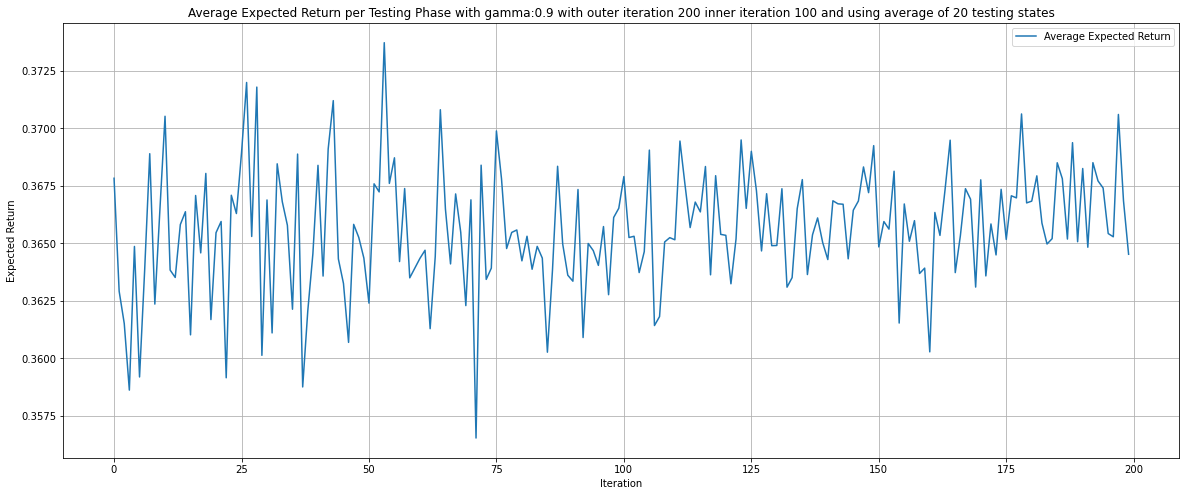

In [47]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 8))  # Adjust width and height as needed

# Plotting
plt.plot(expected_return_history, label='Average Expected Return')
plt.xlabel('Iteration')
plt.ylabel('Expected Return')
plt.grid()
plt.title(f'Average Expected Return per Testing Phase with gamma:{gamma} with outer iteration {outer_iterations} inner iteration {max_episodes} and using average of {num_test_states} testing states')
plt.legend()
plt.show()


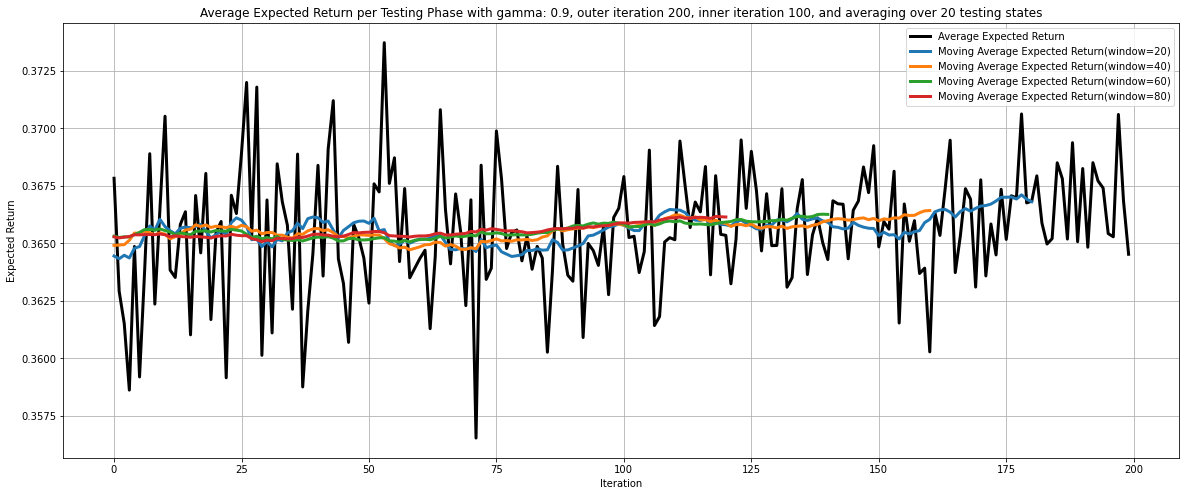

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Compute moving averages with different window sizes
moving_average20 = np.convolve(expected_return_history, np.ones(20) / 20, mode='valid')
moving_average40 = np.convolve(expected_return_history, np.ones(40) / 40, mode='valid')
moving_average60 = np.convolve(expected_return_history, np.ones(60) / 60, mode='valid')
moving_average80 = np.convolve(expected_return_history, np.ones(80) / 80, mode='valid')

# Plotting with larger figure size
plt.figure(figsize=(20, 8))
plt.plot(expected_return_history, label='Average Expected Return', color='black', linewidth=3)
plt.plot(moving_average20, label='Moving Average Expected Return(window=20)', linewidth=3)
plt.plot(moving_average40, label='Moving Average Expected Return(window=40)', linewidth=3)
plt.plot(moving_average60, label='Moving Average Expected Return(window=60)', linewidth=3)
plt.plot(moving_average80, label='Moving Average Expected Return(window=80)', linewidth=3)

# Add labels, title, grid, and legend
plt.xlabel('Iteration')
plt.ylabel('Expected Return')
plt.grid()
plt.title(f'Average Expected Return per Testing Phase with gamma: {gamma}, outer iteration {outer_iterations}, inner iteration {max_episodes}, and averaging over {num_test_states} testing states')
plt.legend()
plt.show()

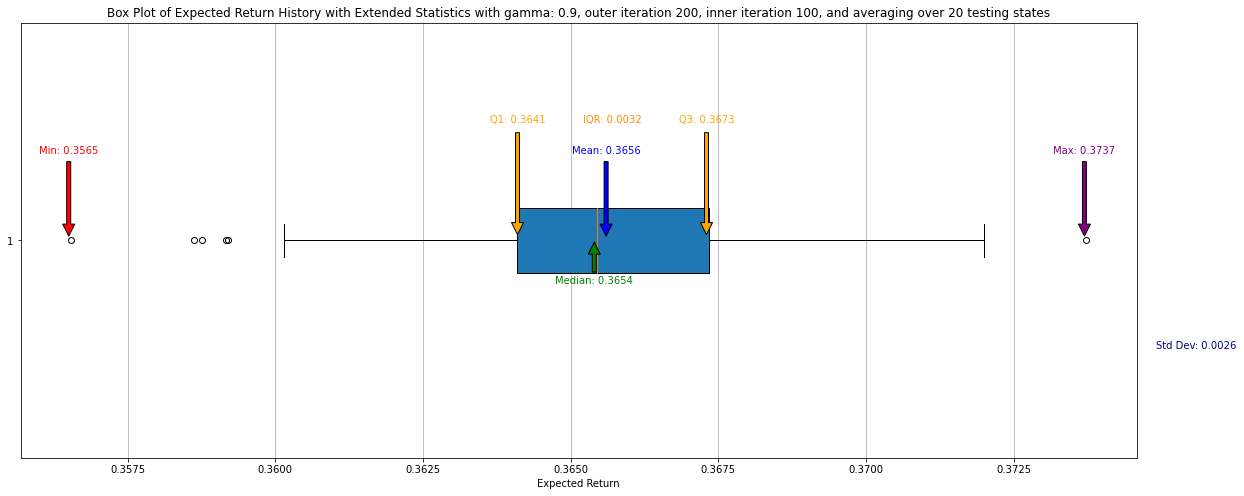

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Creating the box plot with extended statistical annotations
plt.figure(figsize=(20, 8))
plt.boxplot(expected_return_history, vert=False, patch_artist=True)

# Calculate extended statistical properties
mean = round(np.mean(expected_return_history), 4)
median = round(np.median(expected_return_history), 4)
min_val = round(min(expected_return_history), 4)
max_val = round(max(expected_return_history), 4)
q1 = round(np.percentile(expected_return_history, 25), 4)
q3 = round(np.percentile(expected_return_history, 75), 4)
iqr = round(q3 - q1, 4)  # Interquartile Range
std_dev = round(np.std(expected_return_history), 4)

# Add annotations for each value
plt.annotate(f'Mean: {mean}', xy=(mean, 1), xytext=(mean, 1.20), ha='center', color='blue',
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.annotate(f'Median: {median}', xy=(median, 1), xytext=(median, 0.9), ha='center', color='green',
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate(f'Min: {min_val}', xy=(min_val, 1), xytext=(min_val, 1.20), ha='center', color='red',
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate(f'Max: {max_val}', xy=(max_val, 1), xytext=(max_val, 1.20), ha='center', color='purple',
             arrowprops=dict(facecolor='purple', shrink=0.05))
plt.annotate(f'Q1: {q1}', xy=(q1, 1), xytext=(q1, 1.27), ha='center', color='orange',
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.annotate(f'Q3: {q3}', xy=(q3, 1), xytext=(q3, 1.27), ha='center', color='orange',
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.annotate(f'IQR: {iqr}', xy=(q1 + iqr / 2, 1), xytext=(q1 + iqr / 2, 1.27), ha='center', color='darkorange')
plt.annotate(f'Std Dev: {std_dev}', xy=(mean, 0.8), xytext=(mean + 0.01, 0.75), ha='center', color='darkblue')

# Labels and Title
plt.xlabel('Expected Return')
plt.title(f'Box Plot of Expected Return History with Extended Statistics with gamma: {gamma}, outer iteration {outer_iterations}, inner iteration {max_episodes}, and averaging over {num_test_states} testing states')
plt.grid(axis='x')

plt.show()

In [95]:
db.close()